# AdamW

## Definition: AdamW (Decoupled Weight Decay Adam)

AdamW (Loshchilov & Hutter, 2017) is a corrected form of Adam that fixes the
interaction between Adam’s adaptive learning rates and L2 regularization.
In standard Adam, “weight decay” is implemented as an L2 penalty added directly
to the gradient. Because Adam rescales gradients by the second-moment estimate,
this penalty is also rescaled, causing the effective regularization strength to
vary unpredictably across parameters.

AdamW removes this coupling by **decoupling weight decay from the gradient
update**. The gradient is used for optimization exactly as in Adam, while the
parameter shrinkage is applied as an independent step.

Given the Adam first- and second-moment estimates
$$
\begin{align*}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) g_t,\\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) g_t^2,
\end{align*}
$$
and their bias-corrected forms
$$
\hat m_t = \frac{m_t}{1-\beta_1^t},
\qquad
\hat v_t = \frac{v_t}{1-\beta_2^t},
$$
AdamW updates the parameters in two separate steps:

**1) Decoupled weight decay**
$$
\theta_t \leftarrow \theta_t - \eta\, \lambda\, \theta_t,
$$

**2) Adam update**
$$
\theta_{t+1}
= \theta_t
- \eta\,
\frac{\hat m_t}{\sqrt{\hat v_t} + \varepsilon}.
$$

Here $\lambda$ is the weight-decay coefficient, $\eta$ the learning rate, and
$\varepsilon$ a small stability constant.

By keeping weight decay independent from the adaptive gradient rescaling,
AdamW applies a consistent shrinkage to the parameters, leading to more stable
and predictable regularization behavior. Because this shrinkage step is applied
directly to the parameters rather than through the gradient, it is not
equivalent to classical L2 regularization; instead, it provides the correct and
intended form of weight decay for adaptive optimizers. This decoupled
formulation has become the standard choice in modern deep learning
(Transformers, GPT-style models), often outperforming classical Adam in both
convergence and generalization.

## Code: AdamW

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim.optimizer import Optimizer

from models.deep_learning.mlp import MLP

In [2]:
class AdamW(Optimizer):
    """
    Basic Adam optimizer (Kingma & Ba, 2015) with bias correction.
    """
    
    def __init__(
        self,
        params,
        lr: float = 1e-3,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,
    ):
        if lr <= 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        beta1, beta2 = betas
        if not (0.0 < beta1 < 1.0 and 0.0 < beta2 < 1.0):
            raise ValueError(f"Invalid beta values: {betas}")
        if eps <= 0.0:
            raise ValueError(f"Invalid eps: {eps}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay: {weight_decay}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single Adam update step."""
        for group in self.param_groups:
            lr = group["lr"]
            beta1, beta2 = group["betas"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]

            for p in group["params"]:
                grad = p.grad
                if grad is None:
                    continue

                # 1) Decoupled weight decay: θ_t <- θ_t - lr * λ * θ_t
                if weight_decay != 0.0:
                    # θ_t <- θ_t - η λ g_t
                    p.add_(p, alpha=-lr*weight_decay)
                    

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    state["m"] = torch.zeros_like(p)  # first moment
                    state["v"] = torch.zeros_like(p)  # second moment

                m = state["m"]
                v = state["v"]
                state["step"] += 1
                t = state["step"]

                # 1) Update biased first and second moments
                # m_t = β1 m_{t-1} + (1 - β1) g_t      # first moment (momentum-like)
                # v_t = β2 v_{t-1} + (1 - β2) g_t^2    # second moment (variance-like)
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # 2) Compute bias-corrected moments
                # m̂_t = m_t / (1 - β1^t)
                # v̂_t = v_t / (1 - β2^t)
                bias_correction1 = 1 - beta1**t
                bias_correction2 = 1 - beta2**t
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2

                # 3) Parameter update
                # θ_{t+1} = θ_t - lr * m̂_t / (sqrt(v̂_t) + ε)
                p.addcdiv_(m_hat, v_hat.sqrt().add_(eps), value=-lr)

### Data

In [3]:
def f(x):
    return 1+2*x**2

N = 20
xs = (4*torch.rand(N)-2).unsqueeze(1)
ys = f(xs) + 0.5*torch.randn(N).unsqueeze(1)

x = torch.linspace(-2,2,100,requires_grad=True)
x_eval = torch.linspace(-2,2,100)
torch.manual_seed(1)

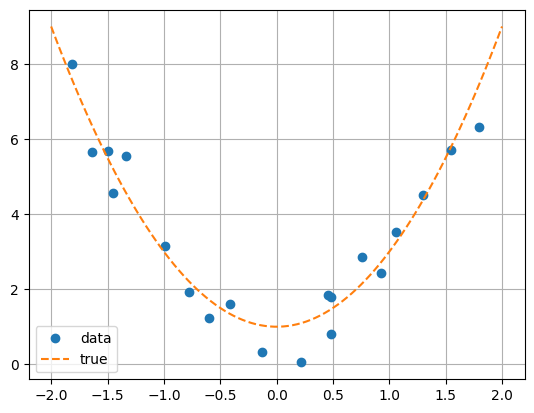

In [4]:
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x.detach().numpy(), f(x).detach().numpy(), '--',label='true')
plt.legend()
plt.grid()
plt.show()


### Training loop

In [5]:
def train(model, opt, loss_fn, data, epochs=20, batch_size=1):
    xs, ys = data
    N = xs.shape[0]
    model.train()
    losses = []
    for epoch in range(epochs):
        perm = torch.randperm(N)  # shuffle for stochasticity each epoch
        for i in range(0, N, batch_size):
            batch_idx = perm[i:i + batch_size]
            x = xs[batch_idx]
            y = ys[batch_idx]
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")   
    return losses

def compare_losses(loss,nn_loss,title):
    plt.plot(nn_loss,linestyle="-",label="nn_loss")
    plt.plot(loss,linestyle="--",label="loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Parameters

In [6]:
lr = 0.001
betas = (0.95, 0.99)
eps = 1e-8
weight_decay = 0.01

loss_fn = nn.MSELoss()  

### pytorch

In [7]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = torch.optim.AdamW(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

nn_loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)

Epoch 1/150, Loss: 16.0678
Epoch 2/150, Loss: 7.9368
Epoch 3/150, Loss: 6.7939
Epoch 4/150, Loss: 7.0441
Epoch 5/150, Loss: 5.1213
Epoch 6/150, Loss: 5.1625
Epoch 7/150, Loss: 5.0525
Epoch 8/150, Loss: 3.4946
Epoch 9/150, Loss: 3.1277
Epoch 10/150, Loss: 3.1394
Epoch 11/150, Loss: 2.1929
Epoch 12/150, Loss: 1.3836
Epoch 13/150, Loss: 1.5116
Epoch 14/150, Loss: 1.1747
Epoch 15/150, Loss: 0.5428
Epoch 16/150, Loss: 0.6972
Epoch 17/150, Loss: 0.8972
Epoch 18/150, Loss: 0.6518
Epoch 19/150, Loss: 0.7683
Epoch 20/150, Loss: 1.0612
Epoch 21/150, Loss: 0.8870
Epoch 22/150, Loss: 0.7482
Epoch 23/150, Loss: 0.8153
Epoch 24/150, Loss: 0.6964
Epoch 25/150, Loss: 0.4804
Epoch 26/150, Loss: 0.4540
Epoch 27/150, Loss: 0.5009
Epoch 28/150, Loss: 0.4551
Epoch 29/150, Loss: 0.4200
Epoch 30/150, Loss: 0.4732
Epoch 31/150, Loss: 0.5276
Epoch 32/150, Loss: 0.5141
Epoch 33/150, Loss: 0.4810
Epoch 34/150, Loss: 0.4782
Epoch 35/150, Loss: 0.4678
Epoch 36/150, Loss: 0.4176
Epoch 37/150, Loss: 0.3700
Epoch 38/

### Custom

Epoch 1/150, Loss: 16.0678
Epoch 2/150, Loss: 7.9368
Epoch 3/150, Loss: 6.7939
Epoch 4/150, Loss: 7.0441
Epoch 5/150, Loss: 5.1213
Epoch 6/150, Loss: 5.1625
Epoch 7/150, Loss: 5.0525
Epoch 8/150, Loss: 3.4946
Epoch 9/150, Loss: 3.1277
Epoch 10/150, Loss: 3.1394
Epoch 11/150, Loss: 2.1929
Epoch 12/150, Loss: 1.3836
Epoch 13/150, Loss: 1.5116
Epoch 14/150, Loss: 1.1747
Epoch 15/150, Loss: 0.5428
Epoch 16/150, Loss: 0.6972
Epoch 17/150, Loss: 0.8972
Epoch 18/150, Loss: 0.6518
Epoch 19/150, Loss: 0.7683
Epoch 20/150, Loss: 1.0612
Epoch 21/150, Loss: 0.8870
Epoch 22/150, Loss: 0.7482
Epoch 23/150, Loss: 0.8153
Epoch 24/150, Loss: 0.6964
Epoch 25/150, Loss: 0.4804
Epoch 26/150, Loss: 0.4540
Epoch 27/150, Loss: 0.5009
Epoch 28/150, Loss: 0.4551
Epoch 29/150, Loss: 0.4200
Epoch 30/150, Loss: 0.4732
Epoch 31/150, Loss: 0.5276
Epoch 32/150, Loss: 0.5141
Epoch 33/150, Loss: 0.4810
Epoch 34/150, Loss: 0.4782
Epoch 35/150, Loss: 0.4678
Epoch 36/150, Loss: 0.4176
Epoch 37/150, Loss: 0.3700
Epoch 38/

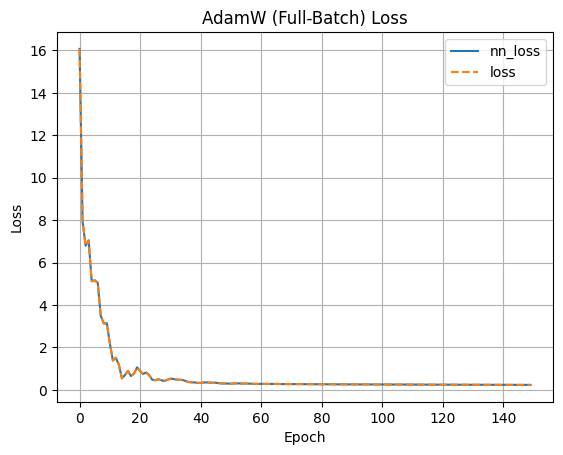

In [8]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = AdamW(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)
compare_losses(loss,nn_loss,"AdamW (Full-Batch) Loss")

# Evaluation

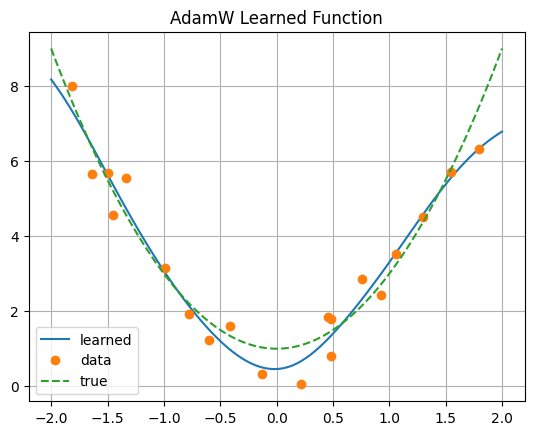

In [9]:
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='learned')
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.title("AdamW Learned Function")
plt.legend()
plt.grid()
plt.show()